<a href="https://colab.research.google.com/github/yusukebb/collective/blob/main/heavy_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc

from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf

# instead of utils
#from utils import *
import pandas as pd
import scipy.ndimage.interpolation as inter
from scipy.signal import medfilt
from scipy.spatial.distance import cdist

In [10]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [11]:
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 15 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_num = 21 # the number of class
        self.feat_d = 105
        self.filters = 64
        self.data_dir = '/content/drive/MyDrive/collective/DD_test/data'
C = Config()

In [12]:
# Temple resizing function
def zoom(p,target_l=64,joints_num=25,joints_dim=3):
    l = p.shape[0]
    p_new = np.empty([target_l,joints_num,joints_dim]) 
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:,m,n] = medfilt(p[:,m,n],3)
            p_new[:,m,n] = inter.zoom(p[:,m,n],target_l/l)[:target_l]         
    return p_new



# Calculate JCD feature
def norm_scale(x):
    return (x-np.mean(x))/np.mean(x)
  
def get_CG(p,C):
    M = []
    iu = np.triu_indices(C.joint_n,1,C.joint_n)
    for f in range(C.frame_l): 
        d_m = cdist(p[f],p[f],'euclidean')       
        d_m = d_m[iu] 
        M.append(d_m)
    M = np.stack(M) 
    M = norm_scale(M)
    return M
  
  
# Genrate dataset  
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

In [13]:
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

In [14]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W])
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
        
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [15]:
DD_Net = build_DD_Net(C)
DD_Net.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 M (InputLayer)                 [(None, 32, 105)]    0           []                               
                                                                                                  
 P (InputLayer)                 [(None, 32, 15, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 4, 512)       1718656     ['M[0][0]',                      
                                                                  'P[0][0]']                      
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 512)         0           ['model_2[0][0]']          

In [21]:
from google.colab import drive
drive.mount('/content/drive')
#Train = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/JHMDB/GT_train_1.pkl", "rb"))
#Train = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/our_train.pkl", "rb"))
#Test = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/our_test.pkl", "rb"))
#Test = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/sit.pkl", "rb"))
#Test = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/jump.pkl", "rb"))
#Test = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/sitandjump.pkl", "rb"))
#Test = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/sitandjump_10000.pkl", "rb"))
#Test = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/modofi.pkl", "rb"))
#Test = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/JHMDB/GT_test_1.pkl", "rb"))
Train = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/ours/train_3D_15.pkl", "rb"))
Test = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/ours/test_3D_15.pkl", "rb"))
#Train = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/ours/train_3D_34.pkl", "rb"))
#Test = pickle.load(open("/content/drive/MyDrive/collective/DD_test/data/ours/test_3D_34.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

Mounted at /content/drive


100%|██████████| 108/108 [00:00<00:00, 173.03it/s]


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=300,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )
"""lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=70,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )"""

Epoch 1/300
1/1 [==============================] - 8s 8s/step - loss: 3.7554 - accuracy: 0.0298 - val_loss: 3.0232 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/300
1/1 [==============================] - 2s 2s/step - loss: 3.0832 - accuracy: 0.1362 - val_loss: 3.0197 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/300
1/1 [==============================] - 3s 3s/step - loss: 2.8250 - accuracy: 0.2213 - val_loss: 3.0108 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/300
1/1 [==============================] - 4s 4s/step - loss: 2.4435 - accuracy: 0.3234 - val_loss: 2.9973 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 5/300
1/1 [==============================] - 4s 4s/step - loss: 2.1430 - accuracy: 0.4596 - val_loss: 2.9806 - val_accuracy: 0.2963 - lr: 0.0010
Epoch 6/300
1/1 [==============================] - 2s 2s/step - loss: 1.8223 - accuracy: 0.6085 - val_loss: 2.9610 - val_accuracy: 0.3519 - lr: 0.0010
Epoch 7/300
1/1 [==============================] - 2s 2s/step - loss: 1.7250 - accuracy: 0.676

'lr = 1e-4\nDD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=[\'accuracy\'])\nlrScheduler = keras.callbacks.ReduceLROnPlateau(monitor=\'loss\', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)\nhistory = DD_Net.fit([X_0,X_1],Y,\n                    batch_size=len(Y),\n                    epochs=70,\n                    verbose=True,\n                    shuffle=True,\n                    callbacks=[lrScheduler],\n                    validation_data=([X_test_0,X_test_1],Y_test)      \n                    )'

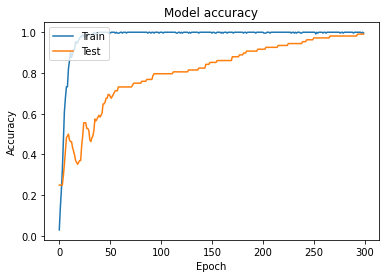

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

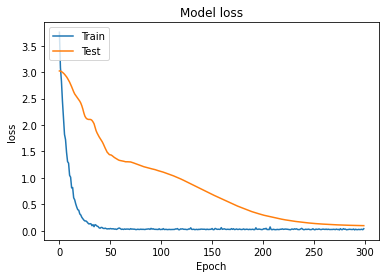

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()